In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rouge

import numpy as np
import pandas as pd

import re
import string
import csv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
from rouge import Rouge
import pandas as pd
from sklearn.model_selection import train_test_split

# Preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/bbc-news-summary.csv')

train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [ ]:
train_data = train_data.drop(['File_path'], axis=1)
train_data = train_data.reset_index(drop=True)
test_data = test_data.drop(['File_path'], axis=1)
test_data = test_data.reset_index(drop=True)

In [ ]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)

    return text

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

clean_summaries = []
for summary in train_data.Summaries:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete')

clean_texts = []
for text in train_data.Articles:
    clean_texts.append(clean_text(text))
print('Cleaning Texts Complete')
# del train_data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Cleaning Summaries Complete
Cleaning Texts Complete


In [ ]:
train_data.Articles[0]

'Assembly ballot papers \'missing\'..Hundreds of ballot papers for the regional assembly referendum in the North East have "disappeared"...Royal Mail says it is investigating the situation, which has meant about 300 homes in County Durham are not receiving voting packs. Officials at Darlington Council are now in a race against time to try and rectify the situation. The all-postal votes of about two million electors are due to be handed in by 4 November. A spokesman for Darlington Council said: "We have sent out the ballot papers, the problem is with Royal Mail. "Somewhere along the line, something has gone wrong and these ballot papers have not been delivered. "The Royal Mail is investigating to see if they can find out what the problem is."..A spokeswoman for Royal Mail said: "We are investigating a problem with the delivery route in the Mowden area of Darlington. "This is affecting several hundred properties, which have failed to receive ballot papers. "We are working closely with th

In [ ]:
clean_texts[0]

'assembly ballot papers missing hundreds ballot papers regional assembly referendum north east disappeared royal mail says investigating situation meant 300 homes county durham receiving voting packs officials darlington council race time try rectify situation postal votes two million electors due handed 4 november spokesman darlington council said sent ballot papers problem royal mail somewhere along line something gone wrong ballot papers delivered royal mail investigating see find problem spokeswoman royal mail said investigating problem delivery route mowden area darlington affecting several hundred properties failed receive ballot papers working closely council help rectify problem one receive ballot paper special hand deliveries take place necessary unaware problems kind regional assembly vote darlington council spokesman added initially complaints couple residents mowden say thought ballot papers made investigations became clear bigger issue spokeswoman electoral commission told

In [ ]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_texts[:110000]
clean_df['summary'] = clean_summaries[:110000]
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')
del clean_texts
del clean_summaries

In [ ]:
clean_df['text'][0]

'assembly ballot papers missing hundreds ballot papers regional assembly referendum north east disappeared royal mail says investigating situation meant 300 homes county durham receiving voting packs officials darlington council race time try rectify situation postal votes two million electors due handed 4 november spokesman darlington council said sent ballot papers problem royal mail somewhere along line something gone wrong ballot papers delivered royal mail investigating see find problem spokeswoman royal mail said investigating problem delivery route mowden area darlington affecting several hundred properties failed receive ballot papers working closely council help rectify problem one receive ballot paper special hand deliveries take place necessary unaware problems kind regional assembly vote darlington council spokesman added initially complaints couple residents mowden say thought ballot papers made investigations became clear bigger issue spokeswoman electoral commission told

In [ ]:
clean_df['summary'][0]

'<sostok> a spokesman for darlington council said   we have sent out the ballot papers  the problem is with royal mail a spokeswoman for royal mail said   we are investigating a problem with the delivery route in the mowden area of darlington the darlington council spokesman added   initially we had complaints from a couple of residents in mowden to say they thought they should have had their ballot papers by now she said the commission was satisfied that measures had been put in place to ensure all voters received ballot papers in time hundreds of ballot papers for the regional assembly referendum in the north east have  disappeared   the royal mail is investigating to see if they can find out what the problem is   no one will not receive their ballot paper as special hand deliveries will take place where necessary  <eostok>'

# Tokenizing Text And Summary Data

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.1, random_state=0)
del clean_df

In [ ]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  59.073145553753136
Total Coverage of rare words:  6.016302428689135
Text Vocab:  11101


In [ ]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count-count
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  72.16036826892196
Total Coverage of rare words:  7.951277543768715
Summary Vocab:  5201


In [ ]:
maxlen_text = 800
maxlen_summ = 150

In [ ]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [ ]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [ ]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (1800, 800)
Target Values Shape (1800, 150)
Test Sequence (201, 800)
Target Test Shape (201, 150)


# Pretrained Embedding

In [ ]:
embeding_index = {}
embed_dim = 100
with open('/content/drive/MyDrive/glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

In [ ]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [ ]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [ ]:
del embeding_index

In [ ]:
train_x

array([[ 182,  183,   58, ...,    0,    0,    0],
       [7002,  949,  827, ...,    0,    0,    0],
       [ 278, 6010, 5606, ...,    0,    0,    0],
       ...,
       [4555,  450,  591, ...,    0,    0,    0],
       [1099,  512, 1569, ...,    0,    0,    0],
       [1229,   96, 1243, ...,    0,    0,    0]], dtype=int32)

In [ ]:
train_x[0].shape

(800,)

In [ ]:
train_x.shape

(1800, 800)

# Model Architecture

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 800)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 800, 100)             1110100   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 256),                234496    ['embedding[0][0]']           
 al)                          (None, 128),                                                    

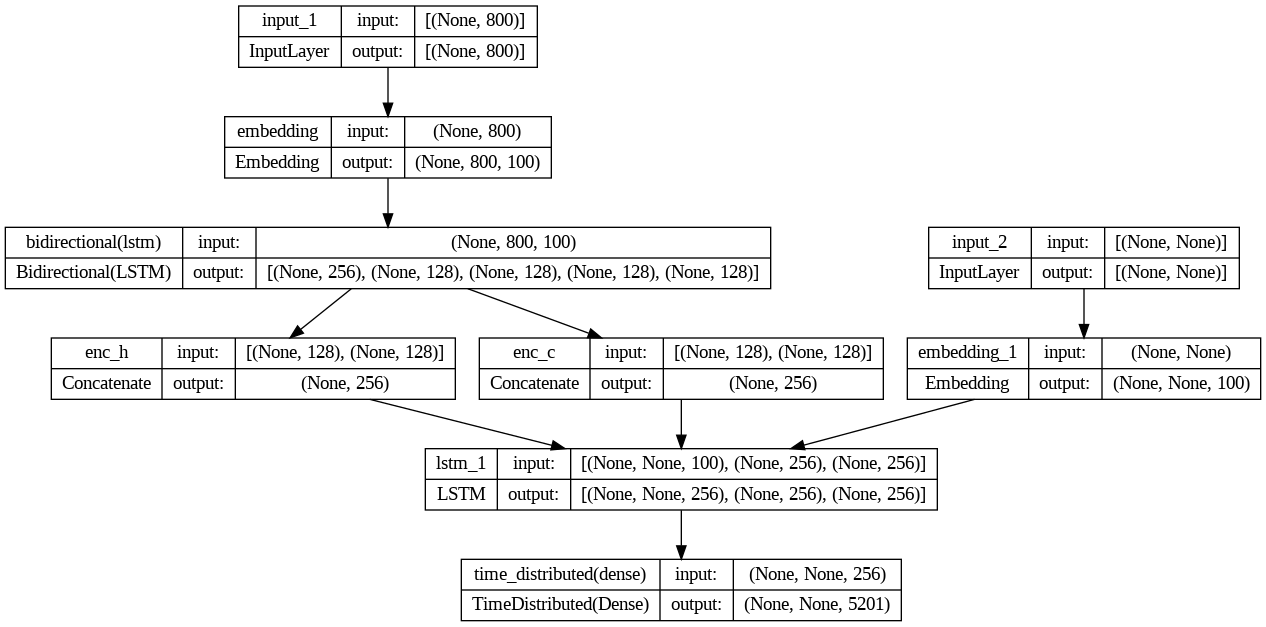

In [ ]:
latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])
#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()

plot_model(
    model,
    to_file='./seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=50, callbacks=[early_stop], batch_size=128, verbose=2, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/50
15/15 - 29s - loss: 7.6680 - accuracy: 0.0711 - val_loss: 6.3384 - val_accuracy: 0.1992 - 29s/epoch - 2s/step
Epoch 2/50
15/15 - 8s - loss: 6.1352 - accuracy: 0.1765 - val_loss: 6.0262 - val_accuracy: 0.1572 - 8s/epoch - 515ms/step
Epoch 3/50
15/15 - 9s - loss: 5.9491 - accuracy: 0.1705 - val_loss: 5.8877 - val_accuracy: 0.1794 - 9s/epoch - 601ms/step
Epoch 4/50
15/15 - 9s - loss: 5.8308 - accuracy: 0.1920 - val_loss: 5.7948 - val_accuracy: 0.1842 - 9s/epoch - 595ms/step
Epoch 5/50
15/15 - 8s - loss: 5.7386 - accuracy: 0.1970 - val_loss: 5.7199 - val_accuracy: 0.1993 - 8s/epoch - 518ms/step
Epoch 6/50
15/15 - 9s - loss: 5.6667 - accuracy: 0.2081 - val_loss: 5.6602 - val_accuracy: 0.2037 - 9s/epoch - 603ms/step
Epoch 7/50
15/15 - 9s - loss: 5.6155 - accuracy: 0.2159 - val_loss: 5.6220 - val_accuracy: 0.2106 - 9s/epoch - 597ms/step
Epoch 8/50
15/15 - 8s - loss: 5.5801 - accuracy: 0.2185 - val_loss: 5.5923 - val_accuracy: 0.2111 - 8s/epoch - 531ms/step
Epoch 9/50
15/15 - 9s - l

In [ ]:
model.save('/content/gdrive/My Drive/path/to/your/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Inference

In [ ]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [ ]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)

    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''

    stop = False
    count = 0

    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])

        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token

        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1

    return output_seq

In [ ]:
test_inputs = [clean_text(sent) for sent in test_data.Articles]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [ ]:
hyps = []
with open('/content/drive/MyDrive/result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(50):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_data.Articles[i], test_data.Summaries[i], our_summ])

1/1 [==============================] - 0s 25ms/step


# ROUGE score

In [3]:
rouge = Rouge()
rouge.get_scores(hyps, test_data.Summaries, avg=True, ignore_empty=True)


{'rouge-1': {'r': 0.03223751990962366,
  'p': 0.391531746031746,
  'f': 0.09238669584278215},
 'rouge-2': {'r': 0.006844075194536959,
  'p': 0.07879466640208328,
  'f': 0.01222480415050086},
 'rouge-l': {'r': 0.031951805623909375,
  'p': 0.38930952380952377,
  'f': 0.0898803667288581}}

